In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf
import time

import models
import flows

In [3]:
# np.random.seed(1234)
# idx = np.random.choice(inputs_0.shape[0], inputs_0.shape[0], replace=False)[:5]
# inputs_0 = inputs_0[idx, :]
# targets_0 = sols[0, ::5, -1:][idx]
# inputs_f = inputs_f
# targets_f = np.zeros(shape=[inputs_f.shape[0], 1])
# sio.savemat(
#     "downstream.mat",
#     {
#         "inputs_0": inputs_0,
#         "targets_0": targets_0,
#         "inputs_f": inputs_f,
#         "targets_f": targets_f,
#         "x": x_test,
#         "t": t_test,
#         "u_ref": sols[:, :, -1],
#     }
# )
data = sio.loadmat("downstream.mat")
inputs_0 = data["inputs_0"]
targets_0 = data["targets_0"]
inputs_f = data["inputs_f"]
targets_f = data["targets_f"]
x_test = data["x"]
t_test = data["t"]
u_ref = data["u_ref"]

#### PINN

In [19]:
model = models.PINN()
loss = model.train(inputs_f, inputs_0, targets_0, niter=30000)

0 0.0558445
1000 0.00014781374
2000 3.5537778e-05
3000 3.69536e-05
4000 3.3429336e-05
5000 3.273639e-05
6000 3.3614102e-05
7000 7.5153606e-05
8000 2.9594838e-05
9000 2.7930782e-05
10000 2.5937486e-05
11000 2.4310637e-05
12000 2.6289843e-05
13000 3.8889244e-05
14000 2.2723634e-05
15000 3.3294655e-05
16000 2.2506303e-05
17000 2.5211322e-05
18000 2.2739785e-05
19000 2.1937121e-05
20000 2.1653466e-05
21000 2.1491824e-05
22000 2.1393327e-05
23000 2.2375436e-05
24000 5.5441313e-05
25000 2.1452437e-05
26000 2.1037526e-05
27000 2.0880541e-05
28000 2.0632722e-05
29000 2.0554617e-05


In [20]:
model.restore()
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = model.call(
    tf.constant(inputs_test, tf.float32)
).numpy()
u_pred = u_pred.reshape([101, 201])

In [21]:
u_ref.shape

(101, 201)

In [22]:
np.linalg.norm(u_ref-u_pred, "fro") / np.linalg.norm(u_ref, "fro")

0.8378370783533113

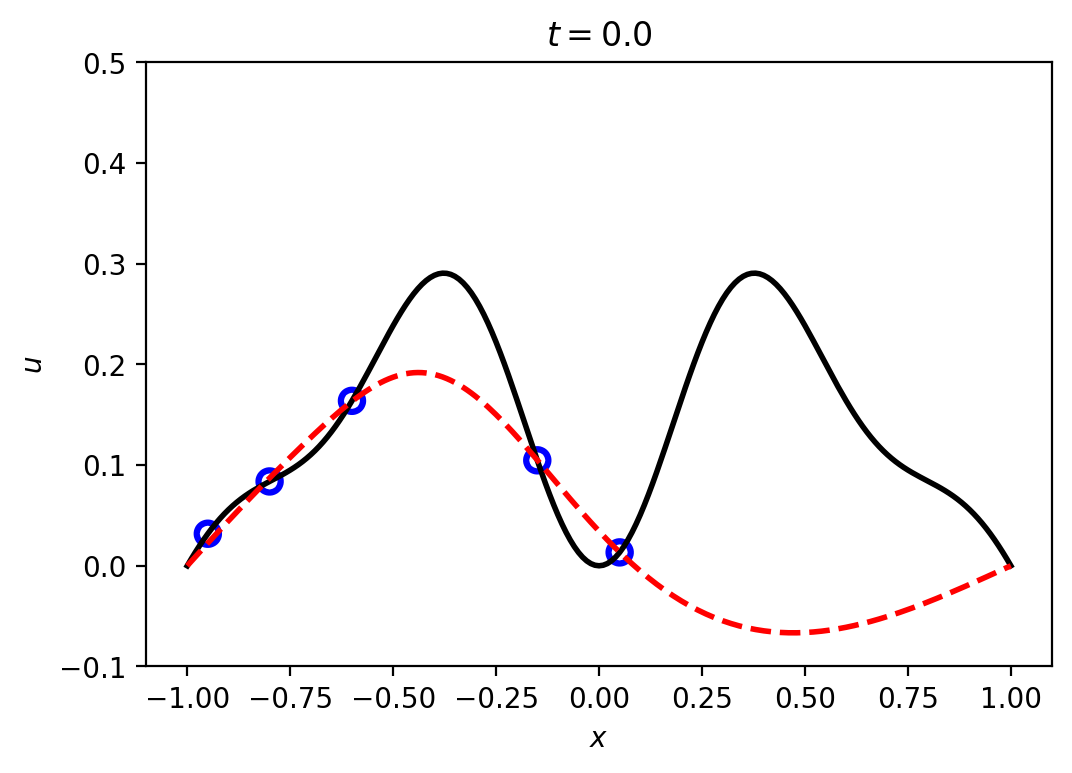

In [23]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 0
ax.scatter(inputs_0[:, 0:1], targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_ref[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_0_no.png")

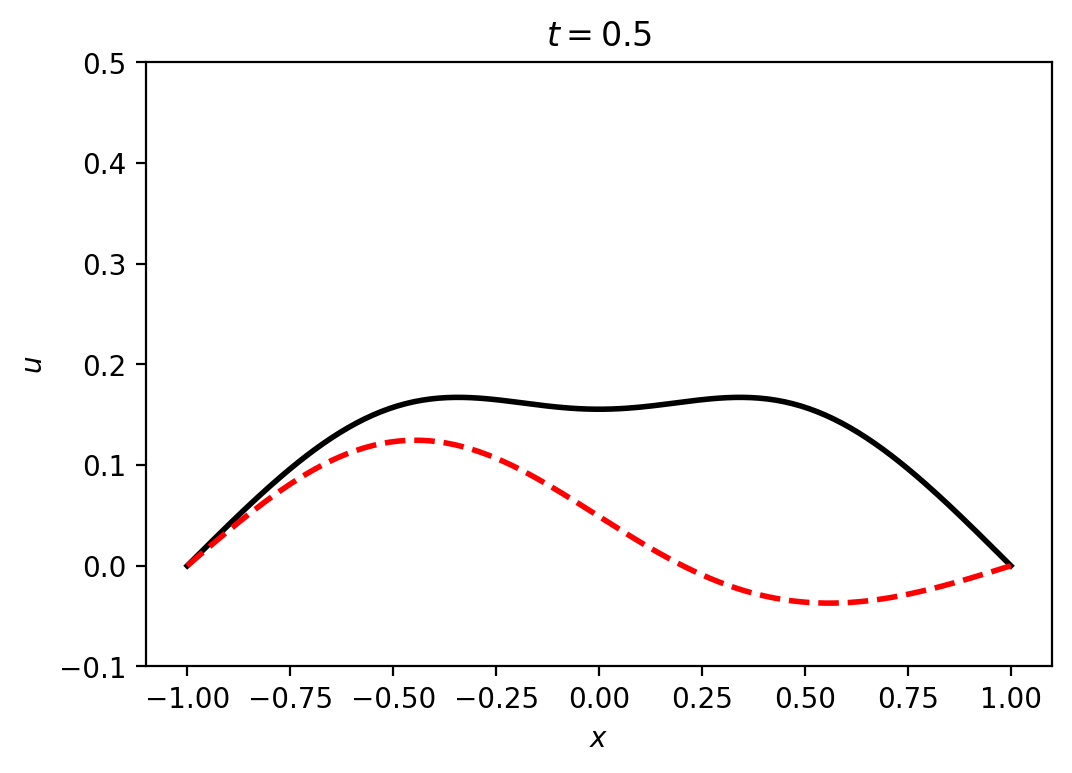

In [24]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 50
# ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_ref[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_1_no.png")

#### MHPINN

In [11]:
mhpinn = models.MHPINN(num_tasks=2000, dim=50, ws=[1, 1], name="mhpinn")
mhpinn.restore()

permutation = list(np.arange(26, 51, 1)) + list(np.arange(0, 26, 1))
nf = flows.MAF(
    dim=51,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf_mhpinn",
)
nf.restore()

In [13]:
ours = models.Downstream(body=mhpinn, flow=nf, dim=50, eps=1e-7)
loss = ours.train(inputs_f, inputs_0, targets_0, niter=20000)

0 0.0010247478
1000 5.8770092e-06
2000 -1.9265715e-05
3000 -2.1496238e-05
4000 -2.2032797e-05
5000 -2.1882775e-05
6000 -1.624691e-05
7000 -2.223556e-05
8000 -2.2335093e-05
9000 -2.2345077e-05
10000 -2.2269436e-05
11000 -2.2342754e-05
12000 -2.2355995e-05
13000 -2.2357252e-05
14000 -2.235804e-05
15000 -2.2358447e-05
16000 -2.232751e-05
17000 -2.2355442e-05
18000 -2.2357932e-05
19000 -2.2359838e-05


In [14]:
ours.restore()
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = ours.call(
    tf.constant(inputs_test, tf.float32)
).numpy()
u_pred = u_pred.reshape([101, 201])

In [15]:
np.linalg.norm(u_ref-u_pred, "fro") / np.linalg.norm(u_ref, "fro")

0.0021678457228260345

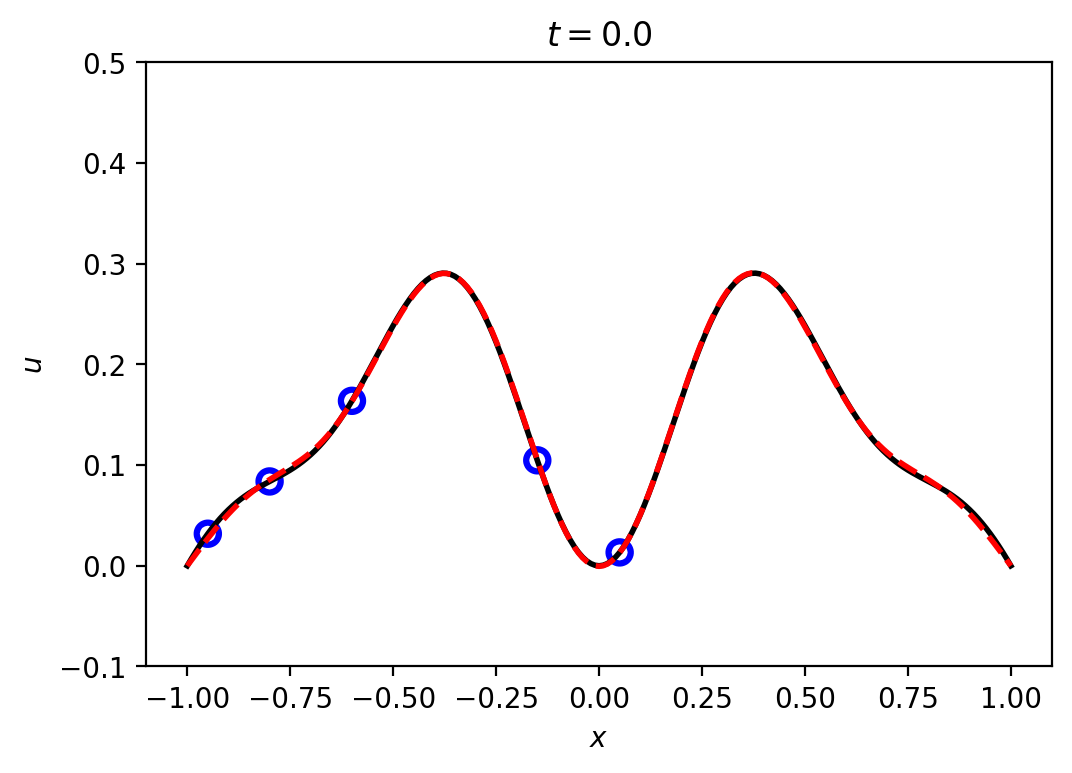

In [17]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 0
ax.scatter(inputs_0[:, 0:1], targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), u_ref[i, :], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_0.png")

In [ ]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot()
i = 50
# ax.scatter(new_inputs_0[:, 0:1], new_targets_0, s=5, color="blue", marker="o", facecolor="none", linewidths=8, label="measurements")
ax.plot(x_test.flatten(), sols[i, :, -1], color="black", linestyle="-", linewidth=2, label="reference")
ax.plot(x_test.flatten(), u_pred[i, :], color="red", linestyle="--", linewidth=2, label="prediction")
# ax.legend(loc=0)
ax.set_ylim([-0.1, 0.5])
ax.set_xlabel("$x$")
ax.set_ylabel("$u$")
ax.set_title("$t=$"+str(t_test[:, i].reshape([])))
ax.set_box_aspect(2/3)
fig.savefig("./figs/u_1_no.png")

In [ ]:
xx_test, tt_test = np.meshgrid(x_test, t_test)
inputs_test = np.concatenate(
    [xx_test.reshape([-1, 1]), tt_test.reshape([-1, 1])], axis=-1
)
u_pred = ours.call(
    tf.constant(inputs_test, tf.float32)
).numpy()
u_pred = u_pred.reshape([101, 201])

u_pred_ref = model.call(
    tf.constant(inputs_test, tf.float32)
).numpy()
u_pred_ref = u_pred_ref.reshape([101, 201])

sio.savemat(
    "gd.mat",
    {
        "inputs_0": inputs_0,
        "targets_0": targets_0,
        "inputs_f": inputs_f,
        "targets_f": targets_f,
        "x": x_test,
        "t": t_test,
        "u_ref": u_ref,
        "u_pred": u_pred, "u_pred_ref": u_pred_ref,
    }
)